# Assignment 2 of GEO1001
## Name: Pratyush
## Student Number: 5359252

#### Imports required: rasterio, matplotlib , seaborn, os, numpy, sklearn    

>You have to classify 2 resolutions:

>1. The whole **60m** image
>2. A **subset** of the **10m** (use rasterio.window)

>These 2 might require different parameters, it is up to you to tell me.

## Imports

In [1]:
import rasterio 
from rasterio import plot # for plotting datasets, may not be of use
from rasterio.plot import show_hist # for showing histogram distribution of bands in a daatset, may not be of use
from rasterio.windows import Window # for clipping out only a window from dataset use in part 2
import matplotlib.pyplot as plt #for plotting images
import numpy as np # for doing computations
import os  # to read file paths to the image data
from sklearn import cluster
%matplotlib inline

## Read sentinel image from assignment

>
| Band 	| Resolution 	| Central Wavelength 	|            Description           	|
|:----:	|:------------:	|:--------------------:	|:--------------------------------:	|
| B1   	| 60 m       	| 443 nm             	| Ultra blue (Coastal and Aerosol) 	|
| B2   	| 10 m       	| 490 nm             	| Blue                             	|
| B3   	| 10 m       	| 560 nm             	| Green                            	|
| B4   	| 10 m       	| 665 nm             	| Red                              	|
| B5   	| 20 m       	| 705 nm             	| vegetation and red edge (VNIR) 	|
| B6   	| 20 m       	| 740 nm             	| vegetation and red edge (VNIR) 	|
| B7   	| 20 m       	| 783 nm             	| vegetation and red edge (VNIR) 	|
| B8   	| 10 m       	| 842 nm             	| Near Infrared (NIR) for FCC    	|
| B8a  	| 20 m       	| 865 nm             	| Narrow Near Infrared (VNIR) 	    |
| B9   	| 60 m       	| 940 nm             	| Water Vapour                  	|
| B10  	| 60 m       	| 1375 nm            	| Short Wave Infrared (SWIR): cirrus       	|
| B11  	| 20 m       	| 1610 nm            	| Short Wave Infrared (SWIR)       	|
| B12  	| 20 m       	| 2190 nm            	| Short Wave Infrared (SWIR)       	|

path = path to all images 
stackpath = list of all paths of required bands 
ds = list of datasets for such bands

# **Part 1**
## Get 60m datasets

npa has all bands stacked as np arrays

[k-means-sentinel-2-python](http://www.acgeospatial.co.uk/k-means-sentinel-2-python/)

In [2]:
path_60 = R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m'
l = os.listdir(path_60)
tostack = l[1:12] #take bands 1 to 12 for 60m dataset
stackpath = [os.path.join(path_60,i) for i in tostack]
ds = [rasterio.open( stackpath[i] , driver='JP2OpenJPEG') for i in  range(len( stackpath ))] # list of datasets    

ds_array= [] #array holding all bands as numpy arrays 
npa = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    #ds_array.append( np.array(ds[i].read(1) , dtype='int32' ) )
    # print(npa)
    #print('bef: ',npa.shape)
    if i==0:
        npa += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        npa = np.dstack((npa , np.array(ds[i].read(1) , dtype='int32' ))  )
    
    # print('after: ',npa.shape)
    # print(npa)
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (npa.shape[0] * npa.shape[1], npa.shape[2])
haha = npa[:, :, :].reshape(new_shape)
haha


array([[ 288,  289,  185, ...,   66,   61,   75],
       [ 387,  294,  192, ...,   67,   68,   81],
       [ 368,  299,  193, ...,   66,   68,   75],
       ...,
       [ 395,  513,  754, ..., 2673, 1731, 2397],
       [ 419,  415,  621, ..., 2403, 1533, 2232],
       [ 342,  621,  881, ..., 3010, 2029, 2429]], dtype=int32)

In [3]:
k_means = cluster.KMeans(n_clusters=10)
k_means.fit(haha)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(npa[:, :, 0].shape)



KMeans(n_clusters=10)

In [ ]:
for i in range(5,9):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(haha)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(npa[:, :, 0].shape)

    comp = rasterio.open('./exports/k_means_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   


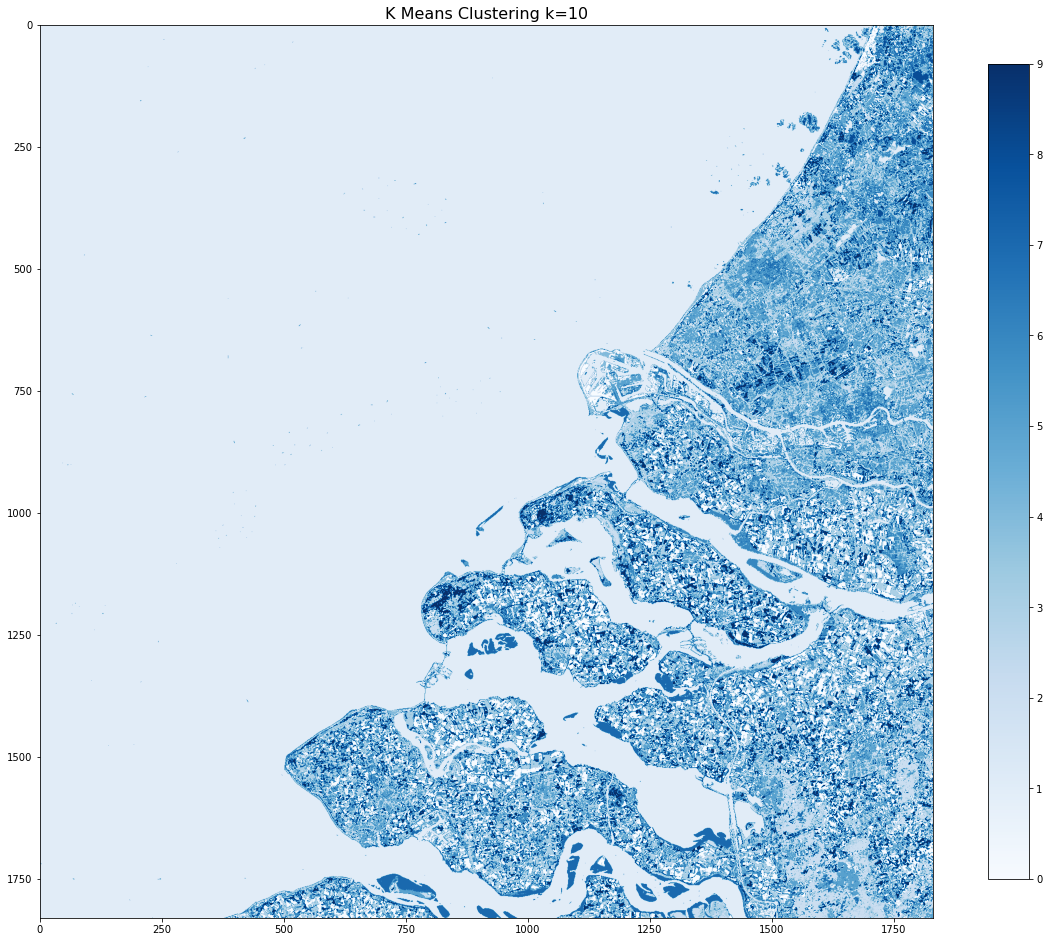

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="Blues")
plt.colorbar(shrink=0.75)
plt.title('K Means Clustering k=10' , fontsize=16)
plt.show()

In [20]:
#save classified image
save_dim = X_cluster.shape
ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds

comp = rasterio.open('./exports/k_means_10.tiff','w', driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
comp.write( X_cluster , 1) 
comp.close()   


In [19]:

save_dim[0]

1830

# **Part 2 begins here**
## subset of 10 m datasets


In [2]:
path_10 =  R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m'
l_10 = os.listdir(path_10)
tostack_10 = l_10[1:5] #take bands B G R NIR for 10m data
stackpath_10 = [os.path.join(path_10,i) for i in tostack_10]
ds_10 = [rasterio.open( stackpath_10[i], driver='JP2OpenJPEG' , window=Window(601200.0, 5773695.0, 700, 500) ) for i in  range(len( stackpath_10 ))] # list of datasets    

bands_10= [] #array holding all bands as numpy arrays 

for i in range( len(ds_10)):
    bands_10.append( np.array(ds_10[i].read(1) , dtype='int32' ) )
    ds_10[i].close()


bands_10 = np.array(bands_10 , dtype='int32') # typecasting from unsigned int to signed
bands_10

array([[[ 277,  302,  282, ...,  297,  325,  318],
        [ 296,  284,  264, ...,  278,  299,  293],
        [ 315,  302,  284, ...,  317,  296,  260],
        ...,
        [ 446,  436,  425, ...,  722,  746,  630],
        [ 450,  415,  464, ...,  744,  736,  741],
        [ 433,  453,  453, ...,  766,  730,  704]],

       [[ 194,  177,  170, ...,  543,  490,  529],
        [ 194,  217,  169, ...,  526,  537,  541],
        [ 211,  209,  183, ...,  539,  537,  456],
        ...,
        [ 581,  570,  575, ..., 1004,  998,  944],
        [ 576,  564,  588, ..., 1009, 1052, 1020],
        [ 566,  586,  575, ..., 1068, 1009, 1001]],

       [[  89,   85,   79, ...,  307,  303,  331],
        [  98,  100,  102, ...,  314,  339,  319],
        [  98,   85,   79, ...,  303,  295,  274],
        ...,
        [ 272,  272,  265, ..., 1278, 1298, 1210],
        [ 285,  257,  273, ..., 1372, 1392, 1308],
        [ 268,  265,  275, ..., 1406, 1312, 1202]],

       [[  78,   69,   62, ..., 3874,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


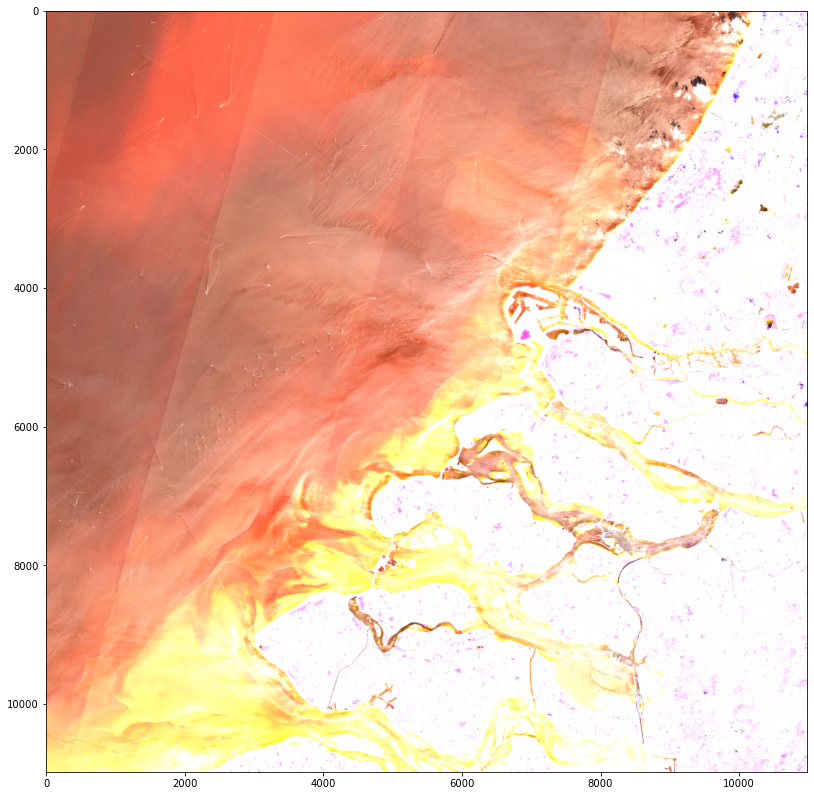

In [59]:
stack = np.dstack( (bands_10[1] , bands_10[2], bands_10[3]) )
fig = plt.figure(figsize=(14,14))
plt.imshow(stack)

In [58]:
bands_10[1]

array([[ 194,  177,  170, ...,  543,  490,  529],
       [ 194,  217,  169, ...,  526,  537,  541],
       [ 211,  209,  183, ...,  539,  537,  456],
       ...,
       [ 581,  570,  575, ..., 1004,  998,  944],
       [ 576,  564,  588, ..., 1009, 1052, 1020],
       [ 566,  586,  575, ..., 1068, 1009, 1001]], dtype=int32)

### Composite bands and save as tif file in exports folder
### Code for making composite image

```python
h , w , dtyp , cr , trans = ds[0].height , ds[0].width , ds[0].dtypes[0] , ds[0].crs ,  ds[0].transform

#create composite bands image
comp = rasterio.open('./exports/compos.tiff','w', driver='Gtiff',
                        width= w, 
                        height=h,
                        count= 4, #4 bands BGR NIR
                        crs=  cr,
                        transform=trans,
                        dtype=dtyp
                        )
# write bands data to the array
for i in range(len(ds)):                        
    comp.write(ds[i].read(1),i+1) #blue
comp.close()      

# Function to normalize the grid values
def normalize(array):
    """ normalizes band for better reading? idk why normalize
    Args:
        array [numpy array]: array inpur from a band of the image
    """
    
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))


NameError: name 'cluster' is not defined